# Traffy Fondue

เป็นแอปพลิเคชั่นสำหรับรับแจ้งปัญหา ข้อเสนอแนะจากผู้แจ้ง และ ระบบสนับสนุนการบริหารจัดการปัญหาให้มีประสิทธิภาพสูงขึ้น โดยผู้แจ้งไม่จำเป็นต้องรู้จักกับเจ้าหน้าที่ หรือทราบว่าใครเป็นผู้รับผิดชอบปัญหามาก่อน ก็สามารถแจ้งปัญหาได้ ระบบออกแบบมาให้ง่ายต่อการใช้งาน เพียงแค่ผู้แจ้งทำการถ่ายรูปและระบุประเภทของปัญหา ระบบจะทำการแจ้งปัญหาดังกล่าวไปยังเจ้าหน้าที่และทีมงานที่รับผิดชอบทันที ในด้านของเจ้าหน้าที่ ระบบจะช่วยคัดแยกประเภทของปัญหาและแจ้งปัญหาต่อเจ้าหน้าที่ผู้ที่มีหน้าที่ดูแลและรับผิดชอบโดยตรง ระบบสามารถให้ข้อมูลความก้าวหน้าในการดำเนินการและติดตามสถานะของปัญหาได้ผ่านโทรศัพท์มือถือ ระบบนี้ช่วยให้ผู้แจ้งมีส่วนร่วมในการดูแลสภาพแวดล้อมของชุมชน(คอนโดมิเนียม, นิคมอุตสาหกรรม, หมู่บ้าน) ของตนเอง และยังเปิดโอกาสให้ผู้แจ้งสามารถให้กำลังใจ ติชมการปฏิบัติงานของเจ้าหน้าที่ได้อีกด้วย ผู้แจ้งและเจ้าหน้าที่สามารถสื่อสารและช่วยกันแก้ไขปัญหาชุมชนร่วมกัน ซึ่งทำให้เกิดความหวงแหน ดูแล รักษา ให้ชุมชน(คอนโดมิเนียม, นิคมอุตสาหกรรม, หมู่บ้าน) มีความน่าอยู่ยิ่งขึ้น

Image classification

10 classes of cases reported from Traffy Fondue
sanitary(ความสะอาด), sewer (ท่อระบายน้ำ), stray (สัตว์จรจัด), canal (คลอง), light (แสงสว่าง), flooding (น้ำท้วม), electric (สายไฟ), traffic (จราจร), road (ถนน), sidewalk (ทางเท้า)

Dataset period: until 2023-02-18

Train 13,274 images, Test 4,648 images

# Download Libraries


In [6]:
!pip install torch

In [7]:
import torch
import math
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

NameError: name '_C' is not defined

# Import Libraries

In [3]:
%matplotlib inline
import pandas
import sklearn
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import re
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import os
import glob

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD
from IPython.display import display
from torchsummaryX import summary
from torch.optim import lr_scheduler

from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.exceptions import UndefinedMetricWarning

# from transformers import get_linear_schedule_with_warmup

from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence, pack_padded_sequence
from torch.nn import Embedding, Dropout, GRU, LSTM, Linear, CrossEntropyLoss 


ModuleNotFoundError: No module named 'matplotlib'

# Mount google drive

In [29]:
# from google.colab import drive
# drive.mount('/content/drive')

In [30]:
# def warn(*args, **kwargs):
#     pass
# import warnings
# warnings.warn = warn

# Load Dataset

In [4]:
device = torch.device("mps")
print(f"Using {device} device")

NameError: name 'torch' is not defined

In [32]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


transform_train = transforms.Compose(
    [transforms.Resize((230,230)),
        transforms.RandomRotation(30,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4303, 0.4301, 0.4139], std=[0.2186, 0.2140, 0.2205]) #nomalize imagenet pretrain
    ])

transform = transforms.Compose(
    [transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4303, 0.4301, 0.4139], std=[0.2186, 0.2140, 0.2205])
    ])


In [74]:
classes = ['canal', 'electric', 'flooding', 'light', 'road', 'sanitary', 'sewer', 'sidewalk', 'stray', 'traffic']
classes_idx = list(range(len(classes)))
classes_idx = dict(zip(classes, classes_idx))
classes_idx

{'canal': 0,
 'electric': 1,
 'flooding': 2,
 'light': 3,
 'road': 4,
 'sanitary': 5,
 'sewer': 6,
 'sidewalk': 7,
 'stray': 8,
 'traffic': 9}

In [75]:
import os
import pandas as pd
import argparse

# parser = argparse.ArgumentParser()
# parser.add_argument('TraffyFondue', type=str,
#                     default='TraffyFondue', help='root dir for data')
# args = parser.parse_args()
# print(args.root)

def gen_filename():
    classes = os.listdir('./train4')
    print(classes)
    d = {}
    for c in classes:
        if c == '.DS_Store':
            continue
        print(c)
        images = os.listdir('./train4/' + c)
        for image in images:
            if image == '.DS_Store': continue
            d[image] = c

    df = pd.DataFrame(d.items(), columns=['filename', 'class'])
    df.to_csv('filenames.csv', index=False)


gen_filename()


['traffic', 'sidewalk', '.DS_Store', 'sanitary', 'sewer', 'road', 'canal', 'light', 'electric', 'flooding', 'stray']
traffic
sidewalk
sanitary
sewer
road
canal
light
electric
flooding
stray


In [76]:
df = pd.read_csv('./filenames.csv')
df

,filename,class
0,train_road_img_1376.jpg,traffic
1,train_canal_img_482.jpg,traffic
2,train_traffic_img_210.jpg,traffic
3,train_traffic_img_576.jpg,traffic
4,train_traffic_img_562.jpg,traffic
...,...,...
7270,train_stray_img_289.jpg,stray
7271,train_stray_img_0.jpg,stray
7272,train_stray_img_276.jpg,stray
7273,train_stray_img_262.jpg,stray


In [77]:
train_data, test_data = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=2023)
test_data, val_data = train_test_split(test_data, test_size=0.5, stratify=test_data['class'], random_state=2023)

In [78]:
train_data.shape

(5820, 2)

In [79]:
test_data.shape

(727, 2)

In [80]:
class TraffyFondueDataset(Dataset):
    
    def __init__(self, 
                 data, 
                 transforms=None):
        
        super().__init__()
        label_image = classes
        self.input_dataset = list()
        for i in range(len(data)):
            img_dir = "./train"
            
            input = [os.path.join(img_dir, data.iloc[i,1].strip(), data.iloc[i,0].strip()), classes_idx[data.iloc[i,1].strip()]] # [image_path, label_num]
            self.input_dataset.append(input)
        
        self.transforms = transforms

    def __len__(self):
        return len(self.input_dataset)

    def __getitem__(self, idx): 
        img = Image.open(self.input_dataset[idx][0]).convert('RGB')
        x = self.transforms(img)
        y = self.input_dataset[idx][1]
        return x,y

trainset = TraffyFondueDataset(train_data, transform_train)
valset = TraffyFondueDataset(val_data,transform)
testset = TraffyFondueDataset(test_data,transform)

# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
# valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)


In [81]:
unique_values, counts = np.unique(df['class'], return_counts=True)
counts_lis = []
label_lis = []
for val, count in zip(unique_values, counts):
    counts_lis.append(count)
    label_lis.append(val)
counts_lis = np.array(counts_lis)
# indices = np.where(counts_lis < 20)[0]

In [82]:
folder_name = []
num_images = []
path = "./train"
for subfolder_name in os.listdir(path):
    # if subfolder_name in ['training', 'testing', 'validating']: continue
    subfolder_path = os.path.join(path, subfolder_name)
    if os.path.isdir(subfolder_path):
        num_image = len([file for file in os.listdir(subfolder_path) if file.endswith(('.jpg', '.png'))])
        num_images.append(num_image)
        folder_name.append(subfolder_name)
        print("Subfolder '{}' contains \t{} images".format(subfolder_name, num_image))



Subfolder 'traffic' contains 	465 images
Subfolder 'sidewalk' contains 	746 images
Subfolder 'sanitary' contains 	450 images
Subfolder 'sewer' contains 	429 images
Subfolder 'road' contains 	1331 images
Subfolder 'canal' contains 	436 images
Subfolder 'light' contains 	790 images
Subfolder 'electric' contains 	941 images
Subfolder 'flooding' contains 	1341 images
Subfolder 'stray' contains 	346 images


In [83]:
def get_weights_inverse_num_of_samples (no_of_classes, samples_per_cls, power = 1) :
    weights_for_samples = 1.0 / np.array (np.power (samples_per_cls, power))
    weights_for_samples = weights_for_samples / np.sum(weights_for_samples) * no_of_classes
    return weights_for_samples

In [84]:
num_classes=10
class_weights = get_weights_inverse_num_of_samples(10,  counts_lis)
class_weights.shape

(10,)

In [85]:
summary_stats = {
    'mean': np.mean(class_weights, axis=0),
    'std': np.std(class_weights, axis=0),
    'min': np.min(class_weights, axis=0),
    'max': np.max(class_weights, axis=0),
}
summary_stats

{'mean': 1.0,
 'std': 0.4219148150537325,
 'min': 0.4372769113599797,
 'max': 1.6947639830454706}

In [86]:
class_weights = torch.Tensor(class_weights).to(device)

In [87]:
BATCH_SIZE = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


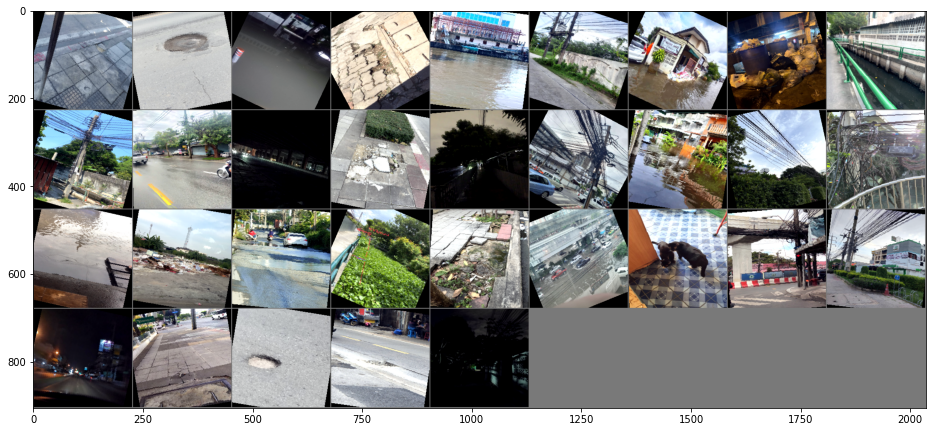

In [88]:
# functions to show an image
def imshow(img):
    img = img*torch.tensor([0.267, 0.256, 0.276]).mean() + torch.tensor([0.507, 0.487, 0.441]).mean()     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
nrow = 9
imshow(torchvision.utils.make_grid(images, nrow = nrow))

In [89]:
# print labels
for i in range(BATCH_SIZE//nrow + 1 if BATCH_SIZE % nrow else 0):
  print(' '.join(f'{labels[i*nrow+j]:<3}' for j in range(min(BATCH_SIZE - i*nrow, nrow))))

7   4   2   7   0   1   2   5   0  
1   2   4   7   3   1   2   1   1  
2   5   2   0   7   2   8   1   1  
3   7   4   4   3  


# Model

In [90]:
device = torch.device("mps")
print(f"Using {device} device")

Using mps device


In [91]:
#pretrain_weight = torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
#net = torchvision.models.efficientnet_v2_s(weights = pretrain_weight)
#net.classifier[1] = nn.Linear(1280, 102)
#net = net.to(device)
#mobile_net 
model_ft = torchvision.models.efficientnet_b0(weights=True)
# model_ft = torchvision.models.resnet50(pretrained=True).to(device)
# model_ft = torchvision.models.vgg16(pretrained=True).to(device)

# Freeze all the pre-trained layers
# for param in model_ft.parameters():
#     param.requires_grad = False
    
model_ft.classifier[-1] = nn.Sequential(
    # nn.Linear(in_features=1280, out_features=1280),
    nn.Linear(in_features=model_ft.classifier[-1].in_features, out_features=num_classes),
    nn.Softmax(dim=1)
        )

model = model_ft.to(device)

/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Hyperparameters Setting

In [92]:
# No special technique
# BATCH_SIZE = 32
NUM_EPOCHS = 3
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: epoch / NUM_EPOCHS)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)

In [93]:
trainset.__len__(), valset.__len__(), testset.__len__()

(5820, 728, 727)

In [94]:
summary(model, torch.zeros((128, 3, 224, 224), dtype = torch.float).to(device))
# import torchinfo
# from torchinfo import summary as summary_info
# summary_info(model, input_size = (128, 3, 224, 224).to(device))

                                                         Kernel Shape  \
Layer                                                                   
0_features.0.Conv2d_0                                   [3, 32, 3, 3]   
1_features.0.BatchNorm2d_1                                       [32]   
2_features.0.SiLU_2                                                 -   
3_features.1.0.block.0.Conv2d_0                         [1, 32, 3, 3]   
4_features.1.0.block.0.BatchNorm2d_1                             [32]   
5_features.1.0.block.0.SiLU_2                                       -   
6_features.1.0.block.1.AdaptiveAvgPool2d_avgpool                    -   
7_features.1.0.block.1.Conv2d_fc1                       [32, 8, 1, 1]   
8_features.1.0.block.1.SiLU_activation                              -   
9_features.1.0.block.1.Conv2d_fc2                       [8, 32, 1, 1]   
10_features.1.0.block.1.Sigmoid_scale_activation                    -   
11_features.1.0.block.2.Conv2d_0                   

/opt/homebrew/lib/python3.10/site-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_features.0.Conv2d_0,"[3, 32, 3, 3]","[128, 32, 112, 112]",864.0,10838016.0
1_features.0.BatchNorm2d_1,[32],"[128, 32, 112, 112]",64.0,32.0
2_features.0.SiLU_2,-,"[128, 32, 112, 112]",NaN,NaN
3_features.1.0.block.0.Conv2d_0,"[1, 32, 3, 3]","[128, 32, 112, 112]",288.0,3612672.0
4_features.1.0.block.0.BatchNorm2d_1,[32],"[128, 32, 112, 112]",64.0,32.0
...,...,...,...,...
219_features.8.SiLU_2,-,"[128, 1280, 7, 7]",NaN,NaN
220_avgpool,-,"[128, 1280, 1, 1]",NaN,NaN
221_classifier.Dropout_0,-,"[128, 1280]",NaN,NaN


# Training Loop

In [95]:
device = torch.device("mps")
print(f"Using {device} device")

Using mps device


In [96]:
from sklearn.metrics import classification_report
from tqdm import tqdm



history_train = {'loss':np.zeros(NUM_EPOCHS), 'acc':np.zeros(NUM_EPOCHS), 'macro_f1-score':np.zeros(NUM_EPOCHS)}
history_val = {'loss':np.zeros(NUM_EPOCHS), 'acc':np.zeros(NUM_EPOCHS), 'macro_f1-score':np.zeros(NUM_EPOCHS)}
min_val_loss = 1e10
PATH = './best_model.pth'

for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    
    print(f'epoch {epoch + 1} \nTraining ...')
    model.train()
    y_predict = list()
    y_labels = list()
    training_loss = 0.0
    n = 0
    with torch.set_grad_enabled(True):
        for inputs, labels in tqdm(trainloader):
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            # print(outputs)
            # print(labels)
            # break
            # print(outputs.shape, labels.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # aggregate statistics
            training_loss += loss.item()
            n+=1

            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
    scheduler.step()

    # print statistics
    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["macro avg"]["f1-score"]
    support = report["macro avg"]["support"]
    training_loss /= n
    print(f"training loss: {training_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )
    history_train['loss'][epoch] = training_loss
    history_train['acc'][epoch] = acc
    history_train['macro_f1-score'][epoch] = f1

    print('validating ...')
    model.eval()
    
    optimizer.zero_grad()
    
    y_predict = list()
    y_labels = list()
    validation_loss = 0.0
    n = 0
    with torch.no_grad():
        for inputs, labels in tqdm(valloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
            n+=1

    # print statistics
    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["macro avg"]["f1-score"]
    # scheduler.step(f1)
    support = report["macro avg"]["support"]
    validation_loss /= n
    print(f"validation loss: {validation_loss:.4}, acc: {acc*100:.4}%, Macro f1-score: {f1*100:.4}%, support: {support}" )
    history_val['loss'][epoch] = validation_loss
    history_val['acc'][epoch] = acc
    history_val['macro_f1-score'][epoch] = f1
    
    #save min validation loss
    if validation_loss < min_val_loss:
        torch.save(model.state_dict(), PATH)
        min_val_loss = validation_loss     
    
print('Finished Training')

epoch 1 
Training ...


100%|██████████| 182/182 [06:45<00:00,  2.23s/it]


training loss: 2.299, acc: 17.63%, f1-score: 3.686%, support: 5820
validating ...


 39%|███▉      | 9/23 [00:08<00:13,  1.02it/s]


KeyboardInterrupt: 

In [1]:
import torch
import math
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


In [ ]:
min_val_loss

In [ ]:
fig, axs = plt.subplots(3, figsize= (6,10))
# loss
axs[0].plot(history_train['loss'], label = 'training')
axs[0].plot(history_val['loss'], label = 'validation')
axs[0].set_title("loss")
axs[0].legend()
# acc
axs[1].plot(history_train['acc'], label = 'training')
axs[1].plot(history_val['acc'], label = 'validation')
axs[1].set_title("acc")
axs[1].legend()
# f1-score
axs[2].plot(history_train['f1-score'], label = 'training')
axs[2].plot(history_val['f1-score'], label = 'validation')
axs[2].set_title("f1-score")
axs[2].legend()
plt.show()

In [ ]:
PATH = './best_model.pth'
model.load_state_dict(torch.load(PATH))

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


print('testing ...')
y_predict = list()
y_labels = list()
test_loss = 0.0
n = 0
with torch.no_grad():
    for data in tqdm(testloader):
        model.eval()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
        n+=1

    # print statistics
    test_loss /= n
    print(f"testing loss: {test_loss:.4}" )
    
    report = classification_report(y_labels, y_predict, digits = 4)
    M = confusion_matrix(y_labels, y_predict)
    print(report)
    disp = ConfusionMatrixDisplay(confusion_matrix=M)

In [ ]:
disp.plot()
plt.show()

In [ ]:
from sklearn.model_selection import KFold

# Define the number of folds to use in k-fold cross-validation
k = 5
kf = KFold(n_splits=k)

# Define the neural network architecture
# class Net(torch.nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = torch.nn.Conv2d(3, 6, 5)
#         self.pool = torch.nn.MaxPool2d(2, 2)
#         self.conv2 = torch.nn.Conv2d(6, 16, 5)
#         self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = torch.nn.Linear(120, 84)
#         self.fc3 = torch.nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(torch.nn.functional.relu(self.conv1(x)))
#         x = self.pool(torch.nn.functional.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = torch.nn.functional.relu(self.fc1(x))
#         x = torch.nn.functional.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# Define the loss function and optimizer
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Perform k-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(trainset)):
    # Split the data into training and validation sets
    trainset_fold = torch.utils.data.Subset(trainset, train_idx)
    testset_fold = torch.utils.data.Subset(trainset, test_idx)
    trainloader = torch.utils.data.DataLoader(trainset_fold, batch_size=BATCH_SIZE,
                                              shuffle=True, num_workers=-1)
    testloader = torch.utils.data.DataLoader(testset_fold, batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=-1)

    # Create a new neural network for each fold

    # Train the network on the training set
    for epoch in range(2):  # Run for two epochs
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # Get the inputs and labels
            inputs, labels = data

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # Print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    # Test the network on the validation set
    correct = 0
    total = 0
    with torch.no_grad


SyntaxError: expected ':' (2903425890.py, line 69)

In [ ]:
# # Initialize variables to store the running mean and standard deviation
# mean = np.zeros(3)
# std = np.zeros(3)

# for i in range(len(df)):
#         img_dir = path
#         img = cv2.imread(os.path.join(img_dir, df.iloc[i,1].strip(), df.iloc[i,0].strip()))
#         img = np.asarray(img)
#         channel_mean = np.mean(img, axis=(0,1))
#         channel_std = np.std(img, axis=(0,1))
#         # Add the channel mean and std to the running total
#         mean += channel_mean
#         std += channel_std
            
# # Calculate the final mean and standard deviation by averaging across all the images
# mean /= len(os.listdir(dataset_path))
# std /= len(os.listdir(dataset_path))

# # Print the final values
# print(f"Mean: {mean}")
# print(f"Std: {std}")

In [26]:
img_dir = './train4'
means = []
std=[]
to_tensor = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
for i in range(len(df)):
    os.path.join(img_dir, df.iloc[i,1].strip(), df.iloc[i,0].strip())
    img = Image.open(os.path.join(img_dir, df.iloc[i,1].strip(), df.iloc[i,0].strip())).convert('RGB')
    tensor = to_tensor(img)
    means.append(tensor.mean(dim=(1,2)))
    std.append(tensor.std(dim=(1,2)))

In [27]:
mean = torch.stack(means, dim=0).mean(dim=0)
std = torch.stack(std, dim=0).mean(dim=0)
print(mean, std)

tensor([0.4303, 0.4301, 0.4139]) tensor([0.2186, 0.2140, 0.2205])


In [4]:
import pandas as pd

In [43]:
dffirefox = pd.read_csv('./firefox/submission85.csv')
dfibrave = pd.read_csv('./mainbravve/submission80.csv')
df8116 = pd.read_csv('./BEST_resources/0.8116/submission500.csv')
df94 = pd.read_csv('submission94.csv')
dfcross = pd.read_csv('BEST_resources/crossval/submissioncross.csv')
dfbest = pd.read_csv('./BEST_resources/0.82449/submission86.csv')

In [44]:
dffirefox_same = dffirefox['class'] == dfbest['class']
dfbrave_same = dfibrave['class'] == dfbest['class']
df8116_same = df8116['class'] == dfbest['class']
df94_same = df94['class'] == dfbest['class']
dfcross_same = dfcross['class'] == dfbest['class']


In [45]:
dffirefox_same_count = dffirefox_same.sum()
dfbrave_same_count = dfbrave_same.sum()
df8116_same_count = df8116_same.sum()
df94_same_count = df94_same.sum()
dfcross_same_count = dfcross_same.sum()
dffirefox_same_percent = (dffirefox_same_count / len(dfbest)) * 100
dfbrave_same_percent = (dfbrave_same_count / len(dfbest)) * 100
df8116_same_percent = (df8116_same_count / len(dfbest)) * 100
df94_same_percent = (df94_same_count / len(dfbest)) * 100
dfcross_same_percent = (dfcross_same_count / len(dfbest)) * 100


In [46]:
dffirefox_same_percent

89.60843373493977

In [47]:
dfbrave_same_percent

87.736660929432

In [48]:
df8116_same_percent

88.96299483648882

In [49]:
df94_same_percent

87.80120481927712

In [50]:
dfcross_same_percent

88.25301204819277

In [15]:
dffirefox[dffirefox['class'] != dfbest['class']]

,ID,class
13,13,0
23,23,0
24,24,1
25,25,3
49,49,6
...,...,...
4606,4606,9
4609,4609,0
4615,4615,9
4622,4622,9


In [17]:
dfibrave[dfibrave['class'] != dfbest['class']]


,ID,class
3,3,9
12,12,6
17,17,7
23,23,4
24,24,1
...,...,...
4609,4609,0
4622,4622,9
4632,4632,4
4634,4634,3


In [18]:
dfibrave[dfibrave['class'] != dffirefox['class']]


,ID,class
3,3,9
12,12,6
13,13,2
17,17,7
23,23,4
...,...,...
4594,4594,7
4599,4599,6
4615,4615,7
4632,4632,4


In [19]:
dffirefox[dfibrave['class'] != dffirefox['class']]


,ID,class
3,3,4
12,12,7
13,13,0
17,17,3
23,23,0
...,...,...
4594,4594,6
4599,4599,7
4615,4615,9
4632,4632,7
